In [1]:
# 1. Import thư viện cần thiết ~33s
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/IMP.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/OPC.csv'
company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/OPC.csv'
df = pd.read_csv(company_csv)
df

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2014-01-02,9910,9910,9850,9850,12650,OPC
1,1,2014-01-03,9150,9910,9150,9910,2160,OPC
2,2,2014-01-06,9450,9850,9450,9850,1090,OPC
3,3,2014-01-07,9850,9850,9850,9850,200,OPC
4,4,2014-01-08,9450,9910,9450,9850,1290,OPC
...,...,...,...,...,...,...,...,...
2463,2463,2023-12-04,22500,22900,22500,22900,15300,OPC
2464,2464,2023-12-05,22900,22900,22900,22900,18500,OPC
2465,2465,2023-12-06,22900,22950,22900,22900,26000,OPC
2466,2466,2023-12-07,22900,22900,22600,22900,19100,OPC


In [3]:
# và gắng index với giá Close cho df1
df1 = df.reset_index()['close']
df1

0        9850
1        9910
2        9850
3        9850
4        9850
        ...  
2463    22900
2464    22900
2465    22900
2466    22900
2467    22900
Name: close, Length: 2468, dtype: int64

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
# scaler
df1

array([[0.11888112],
       [0.12187812],
       [0.11888112],
       ...,
       [0.77072927],
       [0.77072927],
       [0.77072927]])

In [5]:
# 4.1. Chia train test 7 - 2 - 1 len() = 2467 => 7 - 2 - 1 = 1733 495 249
train_size = int(0.7 * len(df1)) #1726
test_size = int(0.2 * len(df1)) #493
val_size = len(df1) - train_size - test_size #248

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# print(train_data) #1733
# print(test_data) #495
# print(val_data) #249

In [6]:
# 5.1. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6.1. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100                                           #     X             --- Y
X_train, y_train = create_dataset(train_data, time_step)  # [0,1,2,...98,99] --- 100
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)

In [8]:
# 7.1. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
# [
    # [[0],[1],[2],...,[99]],
    # [[1],[2],...,[99],[100]],
    # ...
# ]

In [9]:
# 8.1. Define LSTM Model
model_adam_1=Sequential()
model_adam_1.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model_adam_1.add(LSTM(50,return_sequences=True))
model_adam_1.add(LSTM(50))
model_adam_1.add(Dense(1))
model_adam_1.compile(loss='mean_squared_error',optimizer='adam')

model_adadelta_2=Sequential()
model_adadelta_2.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model_adadelta_2.add(LSTM(50,return_sequences=True))
model_adadelta_2.add(LSTM(50))
model_adadelta_2.add(Dense(1))
model_adadelta_2.compile(loss='mean_squared_error',optimizer='adadelta')

# # 8.1. Define LSTM Model
model_rmsprop_3=Sequential()
model_rmsprop_3.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model_rmsprop_3.add(LSTM(50,return_sequences=True))
model_rmsprop_3.add(LSTM(50))
model_rmsprop_3.add(Dense(1))
model_rmsprop_3.compile(loss='mean_squared_error',optimizer='rmsprop')



In [10]:
# 9.1. Fit mô hình với dữ liệu train
model_adam_1.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

model_adadelta_2.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

model_rmsprop_3.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 [==============================] - 12s 269ms/step - loss: 0.0272 - val_loss: 0.0025
Epoch 2/100
26/26 [==============================] - 5s 189ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 3/100
26/26 [==============================] - 4s 160ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 4/100
26/26 [==============================] - 5s 181ms/step - loss: 9.5617e-04 - val_loss: 0.0020
Epoch 5/100
26/26 [==============================] - 6s 218ms/step - loss: 9.1791e-04 - val_loss: 0.0024
Epoch 6/100
26/26 [==============================] - 6s 234ms/step - loss: 9.0121e-04 - val_loss: 0.0018
Epoch 7/100
26/26 [==============================] - 11s 417ms/step - loss: 8.6011e-04 - val_loss: 0.0019
Epoch 8/100
26/26 [==============================] - 9s 352ms/step - loss: 8.3074e-04 - val_loss: 0.0019
Epoch 9/100
26/26 [==============================] - 6s 243ms/step - loss: 8.2497e-04 - val_loss: 0.0020
Epoch 10/100
26/26 [==============================] - 4s 159ms/st

In [11]:
# 10.1. Dự báo dữ liệu test, val
y_train=model_adam_1.predict(X_train) # chua chuan hoa ve VND
y_pred=model_adam_1.predict(X_test) # chua chuan hoa ve VND , con là gtr (0->1)
y_pred_val=model_adam_1.predict(X_val) # chua chuan hoa ve VND

# 10.1. Dự báo dữ liệu test, val
y_train2=model_adadelta_2.predict(X_train) # chua chuan hoa ve VND
y_pred2=model_adadelta_2.predict(X_test) # chua chuan hoa ve VND , con là gtr (0->1)
y_pred_val2=model_adadelta_2.predict(X_val) # chua chuan hoa ve VND

y_train3=model_rmsprop_3.predict(X_train) # chua chuan hoa ve VND
y_pred3=model_rmsprop_3.predict(X_test) # chua chuan hoa ve VND , con là gtr (0->1)
y_pred_val3=model_rmsprop_3.predict(X_val) # chua chuan hoa ve VND

5/5 [==============================] - 0s 32ms/step


In [12]:
# 11.1. Chuẩn hóa dữ liệu (predict) y_pred, y_pred_val về lại VND
y_train=scaler.inverse_transform(y_train)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

# 11.1. Chuẩn hóa dữ liệu (predict) y_pred, y_pred_val về lại VND
y_train2=scaler.inverse_transform(y_train2)
y_pred2=scaler.inverse_transform(y_pred2)
y_pred_val2=scaler.inverse_transform(y_pred_val2)

y_train3=scaler.inverse_transform(y_train3)
y_pred3=scaler.inverse_transform(y_pred3)
y_pred_val3=scaler.inverse_transform(y_pred_val3)

In [13]:
#12
all_posible = []

first_pred =[]

for sublist in [y_train, y_pred, y_pred_val]:
    for item in sublist:
        first_pred.extend(item)
print(first_pred)
all_posible.append(first_pred)

sec_pred =[]
for sublist in [y_train2, y_pred2, y_pred_val2]:
    for item in sublist:
        sec_pred.extend(item)
print(sec_pred)
all_posible.append(sec_pred)

third_pred =[]
for sublist in [y_train3, y_pred3, y_pred_val3]:
    for item in sublist:
        third_pred.extend(item)
print(third_pred)
all_posible.append(third_pred)

[9734.48, 9737.99, 9715.537, 9692.045, 9674.21, 9653.225, 9653.602, 9667.952, 9687.557, 9685.922, 9670.738, 9620.929, 9558.184, 9577.149, 9648.089, 9695.411, 9715.089, 9715.797, 9707.126, 9695.823, 9685.551, 9667.564, 9657.388, 9664.394, 9670.487, 9673.546, 9674.115, 9673.298, 9682.192, 9705.132, 9785.261, 9826.888, 9842.46, 9822.551, 9827.125, 9839.244, 9812.09, 9764.286, 9724.315, 9697.185, 9681.58, 9684.421, 9697.265, 9721.777, 9739.929, 9750.232, 9773.9375, 9803.405, 9811.433, 9804.312, 9790.59, 9776.342, 9754.281, 9720.489, 9684.991, 9654.552, 9631.798, 9577.922, 9549.469, 9543.46, 9530.685, 9512.771, 9494.037, 9477.549, 9484.089, 9504.191, 9498.35, 9484.642, 9469.729, 9476.436, 9476.711, 9460.933, 9446.894, 9456.789, 9471.086, 9474.17, 9468.844, 9459.77, 9440.722, 9447.404, 9470.925, 9470.446, 9452.744, 9419.967, 9383.855, 9360.363, 9348.618, 9354.365, 9369.417, 9376.999, 9369.088, 9370.524, 9361.452, 9345.985, 9329.223, 9314.478, 9303.112, 9295.178, 9280.694, 9272.669, 9270.424,

In [14]:
best_pred= []
# Sử dụng list comprehension để tạo danh sách kết quả
best_pred = [min(item) for item in zip(*all_posible)]

print(best_pred)

[9734.48, 9737.99, 9715.537, 9692.045, 9674.21, 9653.225, 9653.602, 9667.952, 9687.557, 9685.922, 9670.738, 9620.929, 9558.184, 9577.149, 9648.089, 9695.411, 9715.089, 9715.797, 9707.126, 9695.823, 9685.551, 9667.564, 9657.388, 9664.394, 9670.487, 9673.546, 9674.115, 9673.298, 9682.192, 9705.132, 9785.261, 9826.888, 9842.46, 9822.551, 9827.125, 9839.244, 9812.09, 9764.286, 9724.315, 9697.185, 9681.58, 9684.421, 9697.265, 9721.777, 9739.929, 9750.232, 9773.9375, 9803.405, 9811.433, 9804.312, 9790.59, 9776.342, 9754.281, 9720.489, 9684.991, 9654.552, 9631.798, 9577.922, 9549.469, 9543.46, 9530.685, 9512.771, 9494.037, 9477.549, 9484.089, 9504.191, 9498.35, 9484.642, 9469.729, 9476.436, 9476.711, 9460.933, 9446.894, 9456.789, 9471.086, 9474.17, 9468.844, 9459.77, 9440.722, 9447.404, 9470.925, 9470.446, 9452.744, 9419.967, 9383.855, 9360.363, 9348.618, 9354.365, 9369.417, 9376.999, 9369.088, 9370.524, 9361.452, 9345.985, 9329.223, 9314.478, 9303.112, 9295.178, 9280.694, 9272.669, 9270.424,

Evaluate

In [15]:
# 12. Chuẩn hóa dữ liệu (actual) y_train, ytest,yval về lại VND
y_train = y_train.reshape(-1, 1)
ytest = ytest.reshape(-1, 1)
yval = yval.reshape(-1, 1)

y_train = scaler.inverse_transform(y_train) #actual value
ytest = scaler.inverse_transform(ytest) #actual value
yval = scaler.inverse_transform(yval) #acutual value

In [16]:
y_pred_best = best_pred[1631:2025]
y_pred_val_best = best_pred[2026:]
len(y_train),len(ytest),len(yval),len(y_pred_best),len(y_pred_val_best)

(1626, 392, 147, 394, 139)

In [17]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# def evaluateModel(validate, testt)
#   valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
#   test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
#   print('Validation RMSE:', valid_rmse)
#   print('Testing RMSE:', test_rmse)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# # Tính MAE, RMSE, R-square cho testing
# mae_test = mean_absolute_error(ytest, y_pred)
# rmse_test = np.sqrt(mean_squared_error(ytest, y_pred))
# mape_test = calculate_mape(ytest, y_pred)
# r_squared_test = r2_score(ytest, y_pred)

# # Tính MAE, RMSE cho validation
# mae_val = mean_absolute_error(yval, y_pred_val)
# rmse_val = np.sqrt(mean_squared_error(yval, y_pred_val))
# mape_val = calculate_mape(yval, y_pred_val)
# r_squared_val = r2_score(yval, y_pred_val)

# # Tính MAE, RMSE, R-square cho testing
# mae_test = mean_absolute_error(ytest, y_pred2)
# rmse_test = np.sqrt(mean_squared_error(ytest, y_pred2))
# mape_test = calculate_mape(ytest, y_pred2)
# r_squared_test = r2_score(ytest, y_pred2)

# # Tính MAE, RMSE cho validation
# mae_val = mean_absolute_error(yval, y_pred_val2)
# rmse_val = np.sqrt(mean_squared_error(yval, y_pred_val2))
# mape_val = calculate_mape(yval, y_pred_val2)
# r_squared_val = r2_score(yval, y_pred_val2)

# # Tính MAE, RMSE cho validation
# mae_val = mean_absolute_error(yval, y_pred_val)
# rmse_val = np.sqrt(mean_squared_error(yval, y_pred_val))
# mape_val = calculate_mape(yval, y_pred_val)
# r_squared_val = r2_score(yval, y_pred_val)

# # Tính MAE, RMSE, R-square cho testing
# mae_test = mean_absolute_error(ytest, y_pred2)
# rmse_test = np.sqrt(mean_squared_error(ytest, y_pred2))
# mape_test = calculate_mape(ytest, y_pred2)
# r_squared_test = r2_score(ytest, y_pred2)

# # Tính MAE, RMSE cho validation
# mae_val = mean_absolute_error(yval, y_pred_val2)
# rmse_val = np.sqrt(mean_squared_error(yval, y_pred_val2))
# mape_val = calculate_mape(yval, y_pred_val2)
# r_squared_val = r2_score(yval, y_pred_val2)

# Tính MAE, RMSE, R-square cho testing
mae_test = mean_absolute_error(ytest, y_pred3)
rmse_test = np.sqrt(mean_squared_error(ytest, y_pred3))
mape_test = calculate_mape(ytest, y_pred3)
r_squared_test = r2_score(ytest, y_pred3)

# Tính MAE, RMSE cho validation
mae_val = mean_absolute_error(yval, y_pred_val3)
rmse_val = np.sqrt(mean_squared_error(yval, y_pred_val3))
mape_val = calculate_mape(yval, y_pred_val3)
r_squared_val = r2_score(yval, y_pred_val3)

# # Tính MAE, RMSE, R-square cho testing
# mae_test = mean_absolute_error(ytest, y_pred_best)
# rmse_test = np.sqrt(mean_squared_error(ytest, y_pred_best))
# mape_test = calculate_mape(ytest, y_pred_best)
# r_squared_test = r2_score(ytest, y_pred_best)

# # Tính MAE, RMSE cho validation
# mae_val = mean_absolute_error(yval, y_pred_val_best)
# rmse_val = np.sqrt(mean_squared_error(yval, y_pred_val_best))
# mape_val = calculate_mape(yval, y_pred_val_best)
# r_squared_val = r2_score(yval, y_pred_val_best)

# In kết quả
print('---------TEST----------')
print("MAE:", round(mae_val, 3))
print("RMSE:", round(rmse_test, 3))
print("MAPE:", round(mape_test, 3))
print("R-squared:", round(r_squared_test, 3))
print('-------------------')
print('---------VALIDATE----------')
print("MAE:", round(mae_val, 3))
print("RMSE:", round(rmse_val, 3))
print("MAPE:", round(mape_val, 3))
print("R-squared:", round(r_squared_val, 3))
print('--------------------------')


---------TEST----------
MAE: 339.519
RMSE: 592.866
MAPE: 1.544
R-squared: 0.711
-------------------
---------VALIDATE----------
MAE: 339.519
RMSE: 401.771
MAPE: 1.468
R-squared: -1.283
--------------------------


In [19]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=187
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model_rmsprop_3.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_rmsprop_3.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.75874126 0.74675325 0.72827173 0.72827173 0.72827173 0.74675325
 0.71878122 0.71878122 0.71878122 0.72577423 0.70929071 0.72577423
 0.7047952  0.7047952  0.72827173 0.70729271 0.72827173 0.72077922
 0.72827173 0.7982018  0.77522478 0.78871129 0.75174825 0.74425574
 0.75174825 0.77022977 0.78671329 0.78871129 0.77522478 0.75624376
 0.76073926 0.75374625 0.75374625 0.74875125 0.75124875 0.75124875
 0.75124875 0.72927073 0.76573427 0.76323676 0.75124875 0.76323676
 0.75124875 0.76573427 0.75124875 0.75124875 0.7957043  0.7957043
 0.7957043  0.76573427 0.77572428 0.77572428 0.76073926 0.77572428
 0.77572428 0.75824176 0.78571429 0.79070929 0.7982018  0.78071928
 0.78071928 0.77822178 0.79070929 0.78071928 0.79320679 0.78321678
 0.78321678 0.78571429 0.8006993  0.8006993  0.79320679 0.77322677
 0.76823177 0.7957043  0.78071928 0.77572428 0.82067932 0.77322677
 0.77572428 0.78321678 0.77572428 0.77572428 0.78571429 0.78571429
 0.76823177 0.78321678 0.78321678 0.77572428 0.7757

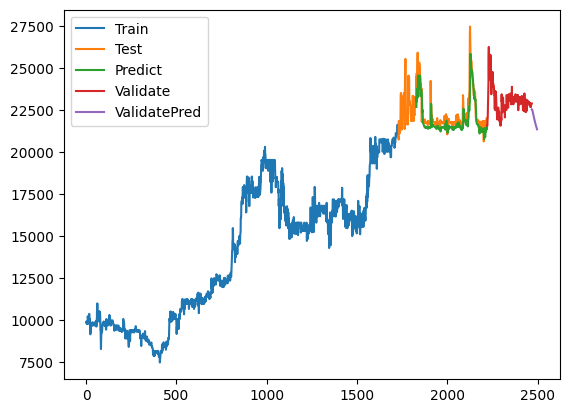

In [20]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
# plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
# plt.figure(figsize=(5,5))
plt.show()